# Task 3: Tidy Up Your Data
**Course:** DLBDSDQDW01 – Data Quality and Data Wrangling  
**Dataset:** Goodreads Books (Kaggle)

---
## 1. Introduction

The goal of this notebook is to demonstrate the process of tidying and cleaning a noisy, untidy dataset.  
I chose the *Goodreads Books* dataset from Kaggle, which contains metadata about thousands of books including titles, authors, ratings, publication details, and ISBN numbers.

The dataset was selected because it exhibits common data quality issues such as missing values, inconsistent data types, duplicates, and outliers.


In [1]:
!pip install fuzzywuzzy python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 52.8 MB/s eta 0:00:00


## 2. Importing Libraries and Loading Data

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from fuzzywuzzy import fuzz, process
import re
from scipy import stats

%matplotlib inline

In [3]:
# Load the dataset
df = pd.read_csv(
    'books.csv',
    sep=',',
    engine='python',
    on_bad_lines='skip'
)
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


## 3. Initial Data Exploration

In [4]:
# Data overview
print("Shape:", df.shape)
df.info()
df.describe()

Shape: (11119, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11119 entries, 0 to 11118
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11119 non-null  int64  
 1   title               11119 non-null  object 
 2   authors             11119 non-null  object 
 3   average_rating      11119 non-null  float64
 4   isbn                11119 non-null  object 
 5   isbn13              11119 non-null  int64  
 6   language_code       11119 non-null  object 
 7     num_pages         11119 non-null  int64  
 8   ratings_count       11119 non-null  int64  
 9   text_reviews_count  11119 non-null  int64  
 10  publication_date    11119 non-null  object 
 11  publisher           11119 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11119.000000,11119.000000,1.111900e+04,11119.000000,1.111900e+04,11119.000000
mean,21308.966184,3.934135,9.759873e+12,336.439788,1.794832e+04,542.167371
std,13093.071002,0.350384,4.430554e+11,241.177969,1.125190e+05,2577.069549
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780586e+12,299.000000,7.450000e+02,47.000000
75%,32103.500000,4.135000,9.780873e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


## 4. Identifying Data Quality Issues

In [5]:
# Check column names for whitespace issues
print("Column names:", df.columns.tolist())

Column names: ['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'publisher']


In [6]:
# Check for missing values
missing = df.isnull().sum()
print("Missing values:\n", missing)

Missing values:
 bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64


In [7]:
# Check for duplicates (based on title and isbn)
duplicates = df[df.duplicated(subset=['title', 'isbn'], keep=False)]
print("Number of duplicates:", len(duplicates))
duplicates.head()

Number of duplicates: 0


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher


In [8]:
# Check for zero pages in num_pages
zero_pages = df[df['  num_pages'] == 0]
print("Number of books with zero pages):", len(zero_pages))
zero_pages.head()

Number of books with zero pages): 76


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
306,955,The 5 Love Languages / The 5 Love Languages Jo...,Gary Chapman,4.70,0802415318,9780802415318,eng,0,22,4,1/1/2005,Moody Publishers
853,2835,The Tragedy of Pudd'nhead Wilson,Mark Twain/Michael Prichard,3.79,140015068X,9781400150687,eng,0,3,0,1/1/2003,Tantor Media
1061,3593,Murder by Moonlight & Other Mysteries (New Adv...,NOT A BOOK,4.00,0743564677,9780743564670,eng,0,7,2,10/3/2006,Simon Schuster Audio
1064,3599,The Unfortunate Tobacconist & Other Mysteries ...,NOT A BOOK,3.50,074353395X,9780743533959,eng,0,12,1,10/1/2003,Simon & Schuster Audio
1230,4249,The Da Vinci Code (Robert Langdon #2),Dan Brown/Paul Michael,3.84,0739339788,9780739339787,eng,0,91,16,3/28/2006,Random House Audio


In [9]:
# Check books with large number of pages
large_pages = df[df['  num_pages'] > 2500]
print("Number of books with large number of pages):", len(large_pages))
large_pages.head()

Number of books with large number of pages): 7


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic
6,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic
6495,24520,The Complete Aubrey/Maturin Novels (5 Volumes),Patrick O'Brian,4.70,039306011X,9780393060119,eng,6576,1338,81,10/17/2004,W. W. Norton Company
6800,25587,The Second World War,Winston S. Churchill/John Keegan,4.45,039541685X,9780395416853,eng,4736,1493,99,5/9/1986,Mariner Books
6820,25709,Summa Theologica 5 Vols,Thomas Aquinas,4.12,0870610635,9780870610639,eng,3020,2734,84,1/1/1981,Christian Classics


In [10]:
# Check for books with a rating of zero
zero_rating = df[df['average_rating'] == 0]
print("Number of books with zero rating):", len(zero_rating))
zero_rating.head()

Number of books with zero rating): 25


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
265,799,Out to Eat London 2002 (Lonely Planet Out to Eat),Lonely Planet/Mark Honan,0.0,1740592050,9781740592055,eng,295,0,0,9/1/2001,Lonely Planet
375,1302,Juiced Official Strategy Guide,Doug Walsh,0.0,0744005612,9780744005615,eng,112,0,0,6/1/2005,BradyGames
987,3351,Open City 6: The Only Woman He Ever Left,Open City Magazine/James Purdy/Daniel Pinchbec...,0.0,189044717X,9781890447175,eng,200,0,0,10/13/2000,Grove Press Open City Books
2531,9337,How To Meditate: An Anthology Of Talks On Medi...,Frederick P. Lenz,0.0,1932206108,9781932206104,eng,228,0,0,1/1/2004,Frederick P. Lenz Foundation for American Budd...
2532,9338,Insights: Talks On The Nature Of Existence,Frederick P. Lenz,0.0,1932206086,9781932206081,eng,304,0,0,1/1/2003,Frederick P. Lenz Foundation for American Budd...


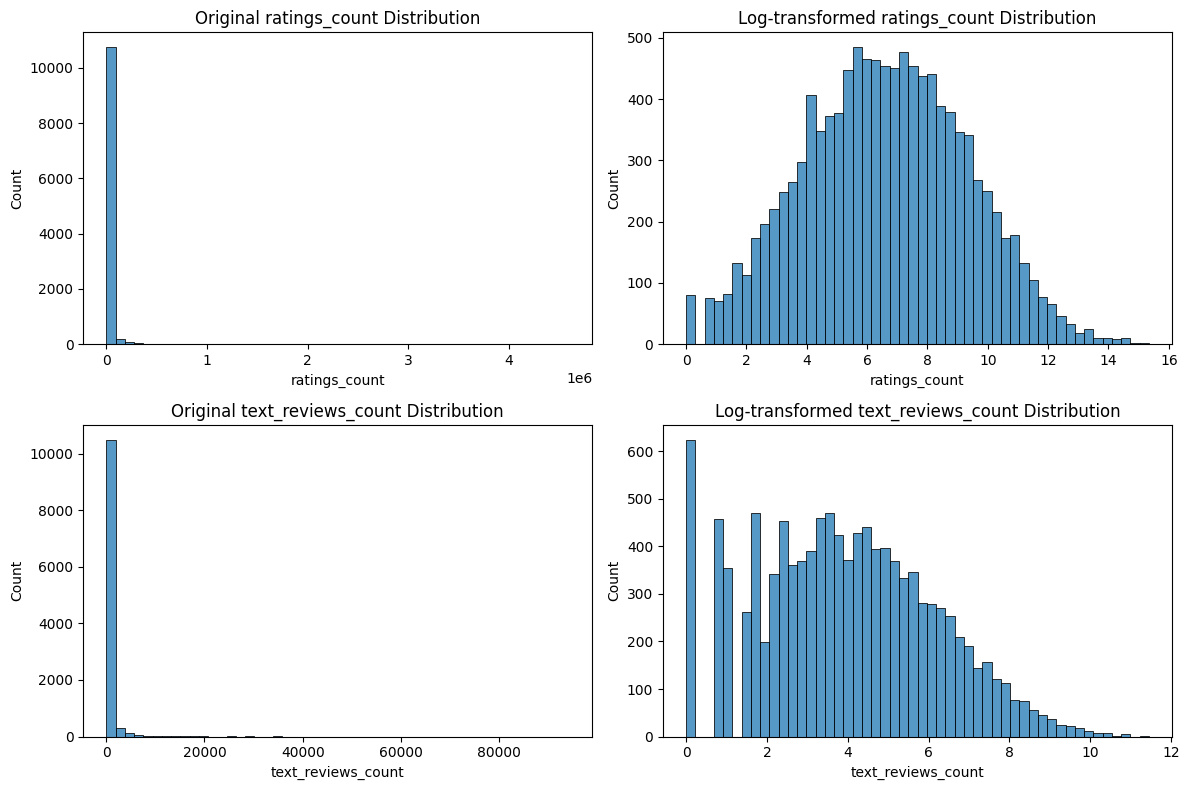

In [11]:
# Visualization: Original and transformed distributions for skewed columns
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df['ratings_count'], bins=50, ax=axes[0,0])
axes[0,0].set_title('Original ratings_count Distribution')
sns.histplot(np.log1p(df['ratings_count']), bins=50, ax=axes[0,1])
axes[0,1].set_title('Log-transformed ratings_count Distribution')
sns.histplot(df['text_reviews_count'], bins=50, ax=axes[1,0])
axes[1,0].set_title('Original text_reviews_count Distribution')
sns.histplot(np.log1p(df['text_reviews_count']), bins=50, ax=axes[1,1])
axes[1,1].set_title('Log-transformed text_reviews_count Distribution')
plt.tight_layout()
plt.show()

In [12]:
# Outlier detection: Z-score, using log for skewed columns (ratings_count, text_reviews_count)
df_temp = df.select_dtypes(include=np.number).copy()
df_temp['ratings_count'] = np.log1p(df_temp['ratings_count'])
df_temp['text_reviews_count'] = np.log1p(df_temp['text_reviews_count'])
z_scores = np.abs(stats.zscore(df_temp))
outliers = (z_scores > 3).any(axis=1)
print("Number of outlier rows:", outliers.sum())
df[outliers].head()

Number of outlier rows: 298


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic
6,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic
21,30,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien,4.59,0345538374,9780345538376,eng,1728,101233,1550,9/25/2012,Ballantine Books
22,31,The Lord of the Rings (The Lord of the Rings ...,J.R.R. Tolkien,4.50,0618517650,9780618517657,eng,1184,1710,91,10/21/2004,Houghton Mifflin Harcourt
24,35,The Lord of the Rings (The Lord of the Rings ...,J.R.R. Tolkien/Alan Lee,4.50,0618260587,9780618260584,en-US,1216,1618,140,10/1/2002,Houghton Mifflin Harcourt


In [13]:
# Fuzzy matching example for noisy publishers (single entities)
sample_publishers = df['publisher'].unique()[:200]
for i in range(len(sample_publishers)):
    for j in range(i+1, len(sample_publishers)):
        score = fuzz.ratio(sample_publishers[i], sample_publishers[j])
        if score > 80 and score < 100:
            print(f"Potential fuzzy match: {sample_publishers[i]} vs {sample_publishers[j]} (Score: {score})")

Potential fuzzy match: Gramercy Books vs Gallery Books (Score: 81)
Potential fuzzy match: Ivy Books vs It Books (Score: 82)
Potential fuzzy match: Farrar  Straus and Giroux vs Farrar Straus Giroux (Score: 89)
Potential fuzzy match: Workman Publishing Company vs Abdo Publishing Company (Score: 82)
Potential fuzzy match: Barnes & Noble Classics vs Barnes  Noble Classics (Score: 98)
Potential fuzzy match: Dover Publications vs Lerner Publications (Score: 81)
Potential fuzzy match: Harper Perennial vs HarperCollins Perennial (Score: 82)
Potential fuzzy match: Simon & Schuster vs Simon  Schuster (Score: 97)
Potential fuzzy match: Atheneum Books for Young Readers vs HMH Books for Young Readers (Score: 81)
Potential fuzzy match: W. W. Norton & Company vs W. W. Norton  Company (Score: 98)
Potential fuzzy match: HarperCollins Publishers vs HarperCollins Publishers  Inc. (Score: 89)
Potential fuzzy match: Oxford University Press vs Oxford University Press  USA (Score: 90)


## 5. Data Cleaning and Wrangling

In [14]:
# Cleansing: Strip whitespace from column names
df.columns = df.columns.str.strip()
print("Cleaned column names:", df.columns.tolist())

Cleaned column names: ['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code', 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'publisher']


In [15]:
# Structuring: Parse publication_date to datetime
df['publication_date'] = pd.to_datetime(df['publication_date'], errors='coerce')

# Structuring: Split authors into separate rows for tidy format
df_tidy = df.copy()
df_tidy['authors'] = df_tidy['authors'].str.split('/')
df_tidy = df_tidy.explode('authors')
print("After splitting authors:")
df_tidy.head()

After splitting authors:


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.
0,1,Harry Potter and the Half-Blood Prince (Harry ...,Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic


In [16]:
df_tidy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19231 entries, 0 to 11118
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   bookID              19231 non-null  int64         
 1   title               19231 non-null  object        
 2   authors             19231 non-null  object        
 3   average_rating      19231 non-null  float64       
 4   isbn                19231 non-null  object        
 5   isbn13              19231 non-null  int64         
 6   language_code       19231 non-null  object        
 7   num_pages           19231 non-null  int64         
 8   ratings_count       19231 non-null  int64         
 9   text_reviews_count  19231 non-null  int64         
 10  publication_date    19228 non-null  datetime64[ns]
 11  publisher           19231 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 1.9+ MB


In [17]:
# Cleansing: Outlier removal (using log for skewed columns)
numeric_cols = ['ratings_count', 'text_reviews_count']
df_tidy_temp = df_tidy[numeric_cols].copy()
df_tidy_temp['ratings_count'] = np.log1p(df_tidy_temp['ratings_count'])
df_tidy_temp['text_reviews_count'] = np.log1p(df_tidy_temp['text_reviews_count'])
df_tidy = df_tidy[(np.abs(stats.zscore(df_tidy_temp)) < 3).all(axis=1)]

In [18]:
# Cleansing: Drop rows where publication date is NaT
df_tidy = df_tidy.dropna(subset=['publication_date'])

In [19]:
# Cleansing: Treating books with zero pages as missing values by dropping key columns
df_tidy = df_tidy[df_tidy['num_pages'] != 0]
df_tidy.shape

(19037, 12)

In [20]:
# Rename num pages column to make it more descriptive
df_tidy = df_tidy.rename(columns={'num_pages': 'page_counts'})

In [21]:
# Cleansing: Standardize language_code
def standardize_language(code):
    if str(code).lower().startswith('en'):
        return 'eng'
    return code
df_tidy['language_code'] = df_tidy['language_code'].apply(standardize_language)

In [22]:
# Fuzzy matching for publishers: standardize and consolidate
def standardize_publisher(publisher):
    return re.sub(r'\s+', ' ', publisher.strip().lower())
df_tidy['publisher'] = df_tidy['publisher'].apply(standardize_publisher)

# Identify and consolidate similar publishers
unique_publishers = df_tidy['publisher'].unique()
top_publishers = df_tidy['publisher'].value_counts().index[:10]

consolidation_map = {}
for canonical in top_publishers:
    matches = process.extract(canonical, unique_publishers, scorer=fuzz.ratio, limit=None)
    for match, score in matches:
        if score > 90 and match != canonical:
            consolidation_map[match] = canonical

df_tidy['publisher'] = df_tidy['publisher'].replace(consolidation_map)

In [23]:
# Normalization and Enrichment
scaler = MinMaxScaler()

# Use existing log-transformed values
df_tidy['log_ratings_count'] = np.log1p(df_tidy['ratings_count'])
df_tidy['log_text_reviews_count'] = np.log1p(df_tidy['text_reviews_count'])

# Scale numerical features into new normalized columns
numeric_cols_to_scale = ['average_rating', 'page_counts', 'log_ratings_count', 'log_text_reviews_count']
df_tidy[[col + '_normalized' for col in numeric_cols_to_scale]] = scaler.fit_transform(df_tidy[numeric_cols_to_scale])

# Enrichment: Add 'year' from publication_date
df_tidy['year'] = df_tidy['publication_date'].dt.year.astype('Int64')

# Enrichment: Create 'popularity_score' using unscaled log_ratings_count and unscaled average_rating
df_tidy['popularity_score'] = df_tidy['log_ratings_count'] * df_tidy['average_rating']

In [24]:
print("Tidied dataset:")
df_tidy.head()

Tidied dataset:


,bookID,title,authors,average_rating,isbn,isbn13,language_code,page_counts,ratings_count,text_reviews_count,publication_date,publisher,log_ratings_count,log_text_reviews_count,average_rating_normalized,page_counts_normalized,log_ratings_count_normalized,log_text_reviews_count_normalized,year,popularity_score
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,2003-11-01,scholastic,8.753687,5.501258,0.884,0.053384,0.616137,0.545912,2003,38.691298
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling,4.78,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,scholastic,10.631736,5.105945,0.956,0.408973,0.748326,0.506684,2004,50.819700
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,scholastic,10.631736,5.105945,0.956,0.408973,0.748326,0.506684,2004,50.819700
5,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,eng,152,19,1,2005-04-26,nimble books,2.995732,0.693147,0.748,0.022966,0.210858,0.068784,2005,11.204039
6,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,2005-09-12,scholastic,10.248601,6.695799,0.946,0.508137,0.721358,0.664451,2005,48.475882


In [25]:
df_tidy.shape

(19037, 20)

In [26]:
df_tidy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19037 entries, 2 to 11118
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   bookID                             19037 non-null  int64         
 1   title                              19037 non-null  object        
 2   authors                            19037 non-null  object        
 3   average_rating                     19037 non-null  float64       
 4   isbn                               19037 non-null  object        
 5   isbn13                             19037 non-null  int64         
 6   language_code                      19037 non-null  object        
 7   page_counts                        19037 non-null  int64         
 8   ratings_count                      19037 non-null  int64         
 9   text_reviews_count                 19037 non-null  int64         
 10  publication_date                   1903

## 6. Example Analysis

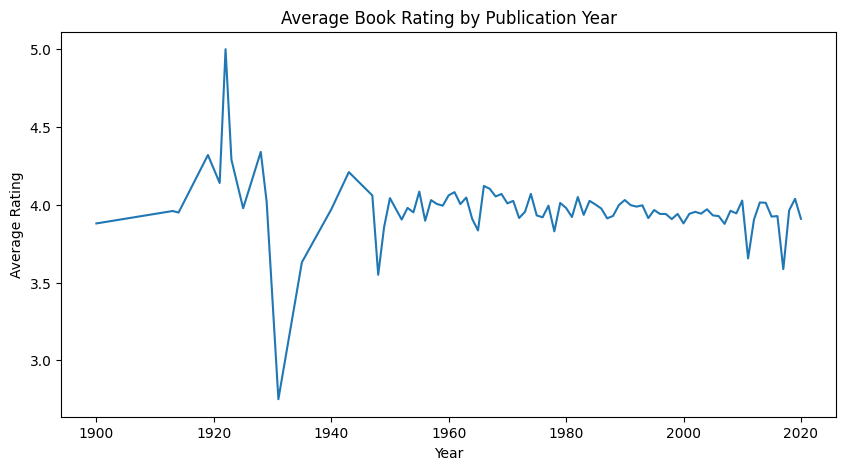

In [27]:
# Visualization: Average rating by year
yearly_avg = df_tidy.groupby('year')['average_rating'].mean()
plt.figure(figsize=(10, 5))
yearly_avg.plot(kind='line')
plt.title('Average Book Rating by Publication Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()